## Персональные наборы данных о медицинских расходах

### 1. Понимание бизнеса

#### 1.1 Цель

Построение прогноза стоимости затрат здравоохранения по медицинскому страхованию

#### 1.2 Информация о наборе данных


* age: возраст основного бенефициара  

* пол: пол страховщика, женский, мужской  

* bmi: индекс массы тела, обеспечивающий понимание тела, вес, который относительно высокий или низкий по отношению к росту,
объективный индекс веса тела (кг / м ^ 2) с использованием отношения роста к весу, в идеале от 18,5 до 24,9  

* дети: количество детей, охваченных медицинским страхованием / количество иждивенцев  

* курильщик: курение  

* регион: жилая зона получателя в США, северо-восток, юго-восток, юго-запад, северо-запад  

* сборы: индивидуальные медицинские расходы, выставленные на счет медицинского страхования

### 2. Понимание данных (Data Understanding)

#### 2.1 Импорт библиотек

In [1]:
# Игнорирование ошибки
import warnings
warnings.filterwarnings('ignore')

# Работа с таблицами и матрицами
import numpy as np
import pandas as pd

# Алгоритмы моделирования
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from lightgbm import  LGBMRegressor, plot_importance
from catboost import CatBoostRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Помощники моделирования
from sklearn import preprocessing, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from tqdm import tqdm
from scipy import linalg, stats
from scipy.stats import norm
import joblib
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL, space_eval
import hyperopt.pyll.stochastic
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss
import re

# Нейронные сети pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Визуализация
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Конфигурация визуализации
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 4,4

#### 2.2 Загрузка данных

In [2]:
df_first = pd.read_csv(r'C:\Users\Urmas\Desktop\Digital\НЕТОЛОГИЯ. ПРОФЕССИЯ DATA SCIENTIST\Диплом\insurance.csv')   # sep = ','   encoding = 'utf-8'
df_first

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df = df_first.copy()   # deep=True новый объект 
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [5]:
# Предикторы (входные данные)
df_X = df.drop('charges', axis=1)

# Целевая переменная
df_y = df['charges']

#### 2.3 Вспомогательные функции

In [6]:
class Class_hyperopt:
    
    def __init__(self):
        self = self
        
    #Зададим функцию, которую будем оптимизировать
    def objective(self, spaces, model, X_train, y_train,
                  cv=KFold(n_splits=10),     # RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
                  scoring='r2',             # 'neg_mean_absolute_error'
                  n_jobs=-1):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.spaces = spaces
        
        self.model.set_params(**self.spaces)
        cross = cross_val_score(self.model, self.X_train, self.y_train, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
        return  {'loss': - cross, 'status': STATUS_OK}         # np.absolute(cross_val)

    def for_hyperopt(self):
        trials = Trials()
        fn = partial(self.objective, model=self.model, X_train=self.X_train, y_train=self.y_train)
        
        try:
            best = fmin(   
                fn=fn,  
                space=self.spaces,
                algo=tpe.suggest,
                max_evals=1000,
                trials=trials,
                rstate=np.random.RandomState(1),
                show_progressbar=True,
                early_stop_fn=no_progress_loss(20)
            )
        
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        
        results = hyperopt.space_eval(self.spaces, best)
        return results

In [7]:
scorr_dataset = pd.DataFrame(columns = ['model', 'name', 'r2', 'cross_val_score'])

In [8]:
predicts = {}

In [9]:
class Class_score_1:
    
    def _init_(self):
        super()._init_()
        
    def get_model(self, model, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
            
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)
        self.y_pred = y_pred
        return self.model

    # Метрики качества 
    def r2(self):
        r_2 = r2_score(self.y_test, self.y_pred)
        self.r_2 = r_2
        return r_2
    
    def MAPE(self):
        return mean_absolute_percentage_error(self.y_test, self.y_pred)
    
    def RMSE (self):
        return mean_squared_error(self.y_test, self.y_pred, squared=False)
    
    def cross_val(self, scoring='r2', cv=KFold(n_splits=10), n_jobs=-1):
        cross = cross_val_score(self.model, self.X_test, self.y_test, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
        self.cross = cross
        return cross
        
    def plot(self):
        plt.figure(figsize=(5,4))
        sns.set_style('dark')
        plot = sns.scatterplot(self.y_test, self.y_pred)
        plot.set(xlabel='Given', ylabel='Prediction')
        x_plot = np.linspace(-1000,60000,100)
        y_plot = x_plot
        plt.plot(x_plot, y_plot, color='r')
        plt.title({self.model})
        plt.grid()
        plt.show()
        
    def leftovers(self):
        plt.scatter(self.model.predict(self.X_train),  self.model.predict(self.X_train) - self.y_train,
            c='blue', marker='o', label='Training data')
        plt.scatter(self.model.predict(self.X_test),  self.model.predict(self.X_test) - self.y_test,
            c='lightgreen', marker='s', label='Test data')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        plt.title({self.model})
        plt.hlines(y=0, xmin=-6000, xmax=60000, lw=2, color='red')
        plt.xlim([-6000, 60000])
        plt.tight_layout()
        
    def data(self, name):
        global scorr_dataset
        global predicts
        
        new_low = pd.DataFrame([[self.model, name, self.r_2, self.cross]], 
                               columns = ['model', 'name', 'r2', 'cross_val_score'])
        scorr_dataset = scorr_dataset.append(new_low, ignore_index=True)
        
        predicts[name] = self.y_pred

In [10]:
class Class_score_2:
    
    def _init_(self):
        super()._init_()
        
    def get_model(self, model, X_train, y_train, X_test, y_test): 
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val
        self.model = model
        
        self.model.fit(self.X_train, self.y_train, eval_metric= "rmse", 
                       eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)])
        
        y_pred = self.model.predict(self.X_test)
        self.y_pred = y_pred
        return self.model

    # Метрики качества 
    def r2(self):
        r_2 = r2_score(self.y_test, self.y_pred)
        self.r_2 = r_2
        return r_2
    
    def MAPE(self):
        return mean_absolute_percentage_error(self.y_test, self.y_pred)
    
    def RMSE (self):
        return mean_squared_error(self.y_test, self.y_pred, squared=False)
    
    def cross_val(self, scoring='r2', cv=KFold(n_splits=10), n_jobs=-1):
        cross = cross_val_score(self.model, self.X_test, self.y_test, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
        self.cross = cross
        return cross
        
    def plot(self):
        plt.figure(figsize=(5,4))
        sns.set_style('dark')
        plot = sns.scatterplot(self.y_test, self.y_pred)
        plot.set(xlabel='Given', ylabel='Prediction')
        x_plot = np.linspace(-1000,60000,100)
        y_plot = x_plot
        plt.plot(x_plot, y_plot, color='r')
        plt.grid()
        plt.show()
        
    def leftovers(self):
        plt.scatter(self.model.predict(self.X_train),  self.model.predict(self.X_train) - self.y_train,
            c='blue', marker='o', label='Training data')
        plt.scatter(self.model.predict(self.X_test),  self.model.predict(self.X_test) - self.y_test,
            c='lightgreen', marker='s', label='Test data')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        plt.hlines(y=0, xmin=-6000, xmax=60000, lw=2, color='red')
        plt.xlim([-6000, 60000])
        plt.tight_layout()
                       
    def plot_importance(self):
        plot_importance(self.model, max_num_features=10)
        plt.show()
        
    def data(self, name):
        global scorr_dataset
        global predicts
        
        new_low = pd.DataFrame([[self.model, name, self.r_2, self.cross]], 
                               columns = ['model', 'name', 'r2', 'cross_val_score'])
        scorr_dataset = scorr_dataset.append(new_low, ignore_index=True)
        
        predicts[name] = self.y_pred

In [11]:
# Функция разделения признака 'bmi' на группы
def bins(x):
    if x<18.5:
        x=1
    elif x<25:
        x=2
    elif x<30:
        x=3
    elif x<35:
        x=4
    elif x<40:
        x=5
    elif x>=40:
        x=6
    return x

### 3. Разведочный анализ данных (EDA)

#### 3.1 Статистика и визуализация

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [13]:
# Проверим наличие пропусков счетно
df.isnull().sum().sum()

0

Подитог: 

- нет пропусков  
- есть категориальные признаки 

In [14]:
# Описательная статистика датасета
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Подитог:
    
- возраст пациентов датасета начинается с 18 лет
- для решения задачи полноценного прогнозирования затрат 'charges' необходим весь охват населения
- признаки 'bmi', 'age'  имеют зашумленные данные

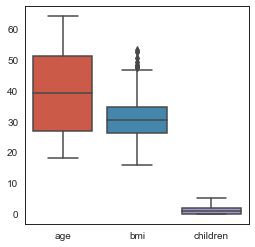

In [15]:
# boxplot (диаграмма размаха)
# Входные данные (предикторы)
sns.boxplot(data=df_X)

Подитог:

- наблюдаем выбросы признака 'bmi' - показатели индекса массы тела. Предположительно, это естественные исключения данных людей с высоким уровнем ожирения
- некоторый диапазон различий значений предикторов: ('age' или 'bmi') и 'children'

Вывод:  

- провести анализ и обработку признака 'bmi' по выбросам  
- учесть особенность распределения признака 'age' - приблизить к нормальному
- убрать зашумленность признаков 'bmi', 'age'
- требуется преобразование категориальных признаков в числовые   
- провести масштабирование данных  

#### 3.2 Распределение целевой переменной

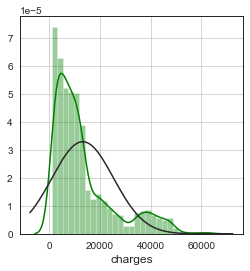

In [16]:
# Проверим нормальное распределение целевой переменной

sns.distplot(df_y, fit=norm, kde=True, color='g')
plt.grid()

Подитог:

- распределение стремится к нормальному, имеется смещение вправо

Количество выбросов целевой переменной - 10.4% (139)
34617.84065


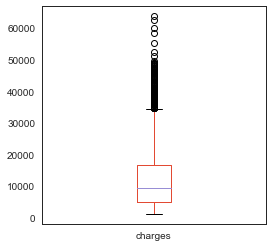

In [17]:
# boxplot (диаграмма размаха) с выбросами
# получим точки с графика и выведем их, используя объект bp

_, bp = df_y.plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in bp['fliers']][0]
min_outliers = outliers.min()

print(f'Количество выбросов целевой переменной - {round(len(outliers)/len(df_y)*100, 2)}% ({len(outliers)})')
print (min_outliers)

In [18]:
# посмотрим на данные датасета при выбросах целевой переменной
df_out_y = df[df['charges'] >= min_outliers]
df_out_y

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1299,45,male,30.360,0,yes,southeast,62592.87309
1300,62,male,30.875,3,yes,northwest,46718.16325
1302,43,male,27.800,0,yes,southwest,37829.72420
1312,19,female,34.700,2,yes,southwest,36397.57600


In [19]:
df_out_y.describe()

,age,bmi,children,charges
count,139.000000,139.000000,139.000000,139.000000
mean,41.079137,35.564604,1.187050,42103.947206
std,13.801420,4.434917,1.126546,5582.168107
min,18.000000,22.895000,0.000000,34617.840650
25%,30.000000,32.667500,0.000000,37786.149950
50%,43.000000,35.200000,1.000000,40974.164900
75%,52.500000,37.660000,2.000000,45786.706425
max,64.000000,52.580000,4.000000,63770.428010


In [20]:
df_out_y['smoker'].value_counts()

yes    136
no       3
Name: smoker, dtype: int64

Вывод:

- в данных имеются естественные аномальные значения (например, 'bmi', 'children'), сочетание некоторых параметров ('smoker' и др.), которые приводят нашу целевую переменную к скошенному распределению и выбросам

#### 3.3 Корреляционный анализ

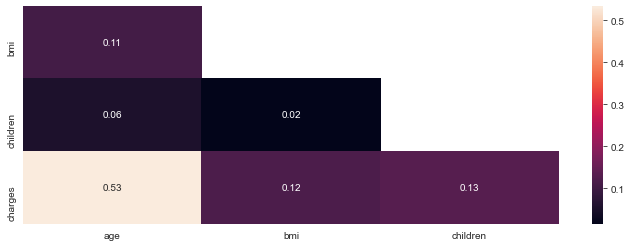

In [21]:
# тепловая карта корреляции может дать нам понимание того, какие переменные важны
corr = df.corr(method = 'spearman')   # коэффициент Спирмена (выбросы)
plt.figure(figsize=[12,4])
mask=np.triu(corr)[1:,:-1]
sns.heatmap(corr.iloc[1:,:-1], mask=mask, annot=True, fmt='.2f')

In [22]:
# важность признаков для целевой переменной, предикторы (высокая корреляция с целевой переменной, прямая и обратная)
corr_high_y = {}
for i, j in corr['charges'].iteritems():
    if i!='charges' and abs(j) > 0.5:
        corr_high_y[i] = j
corr_high_y

{'age': 0.5335232787189861}

In [23]:
# малозначимые признаки для целевой переменной
corr_low_y = {}
for i, j in corr['charges'].iteritems():
    if i!='charges' and abs(j) < 0.1:
        corr_low_y[i] = j
corr_low_y

{}

In [24]:
# проверяем признаки на коллинеарность
collinear = {}

# верхнетреугольная матрица 
f = pd.DataFrame(np.triu(corr.drop(['charges'], axis=1), k=1), index=corr.index, columns=[corr.columns[:-1]])

for i, j in f.iterrows():
    n=0
    for jj in j:
        if i != f.columns[n]:
            if abs(jj) > 0.5:
                collinear[jj] = (i, f.columns[n])
        n+=1
            
collinear

{}

Вывод:  

- корреляционный анализ показал статистически значимую положительную зависимость целевой переменной 'charges' от признака 'age'.      
- проверены признаки на коллинеарность.         
- проверены признаки, не имеющие значимости для целевой переменной 'charges'.     

#### 3.4 Взаимосвязь между признаками

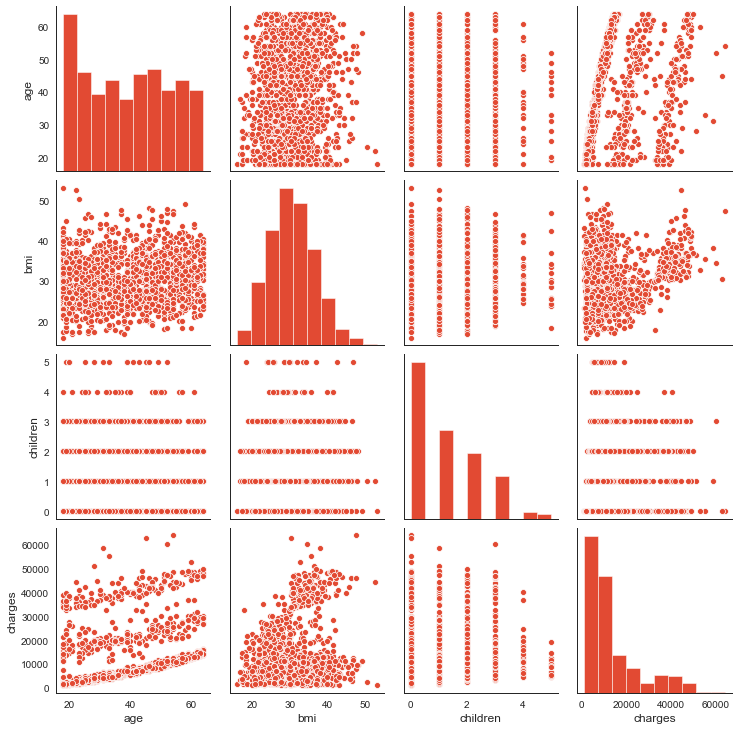

In [25]:
sns.pairplot(df)

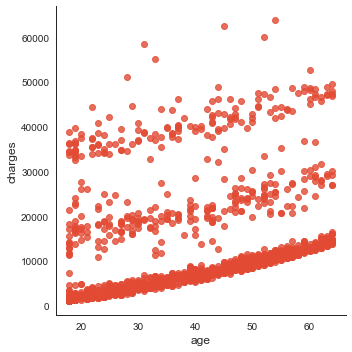

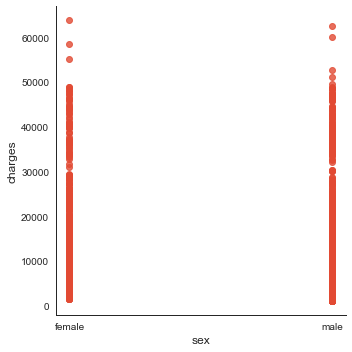

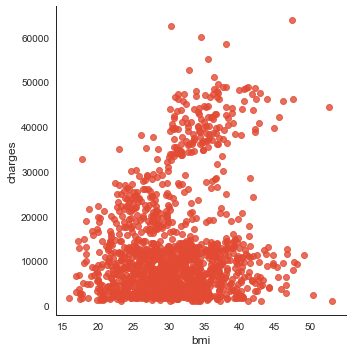

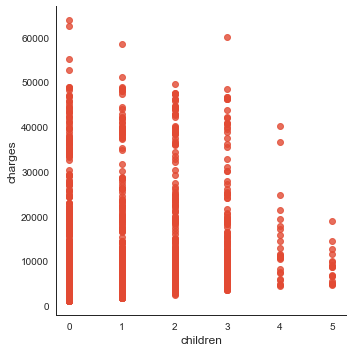

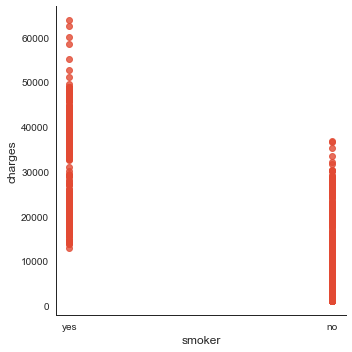

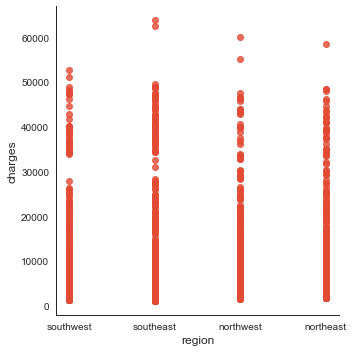

In [26]:
# scatter plot
for i in df_X.columns:
    ax = sns.lmplot(x=i, y="charges", data=df, fit_reg=False)

Обратим внимание на признаки 'age', 'smoker', 'bmi', 'children'
Определим три тренда зависимости 'charges' от 'age'

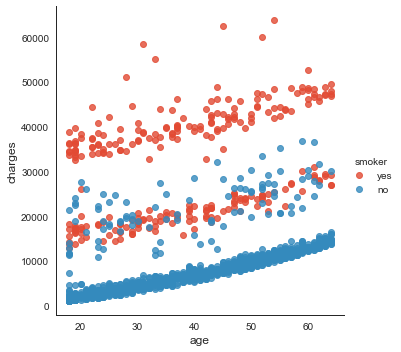

In [27]:
# scatter plot 
ax = sns.lmplot(x="age", y="charges", data=df, fit_reg=False,  hue='smoker')

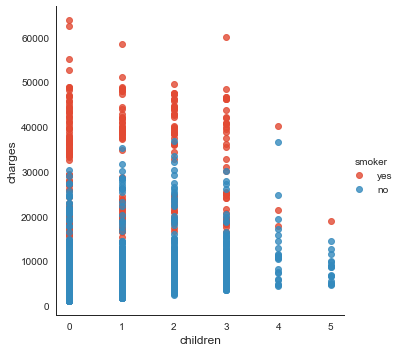

In [28]:
# scatter plot 
ax = sns.lmplot(x="children", y="charges", data=df, fit_reg=False,  hue='smoker')

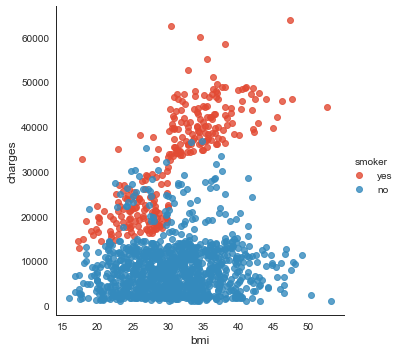

In [29]:
# scatter plot 
ax = sns.lmplot(x="bmi", y="charges", data=df, fit_reg=False,  hue='smoker')

Вывод:  

- признаки 'age', 'smoker', 'bmi', 'children' имеют влияние на целевую переменную 'charges'.    
- признак 'age' связан с целевой переменной 'charges' тремя трендами в зависимости от 'smoker'.     
- признаки 'children' и 'bmi' связаны с целевой переменной 'charges' в зависимости от 'smoker'.     

### 4. Препроцессинг (Data Preparation)

#### 4.1 Выбросы в признаках

Выбросы 'bmi'

Количество выбросов "bmi" - 0.67% (9)
 Min - 47.41
 Max - 53.13


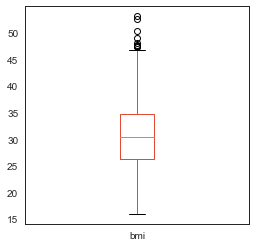

In [30]:
# boxplot (диаграмма размаха) с выбросами
# получим точки с графика и выведем их, используя объект bp

_, bp = df_X['bmi'].plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in bp['fliers']][0]
min_outliers = outliers.min()
max_outliers = outliers.max()

print(f'Количество выбросов "bmi" - {round(len(outliers)/len(df_y)*100, 2)}% ({len(outliers)})')
print (f' Min - {min_outliers}')
print (f' Max - {max_outliers}')

Официальные данные индекса массы тела:
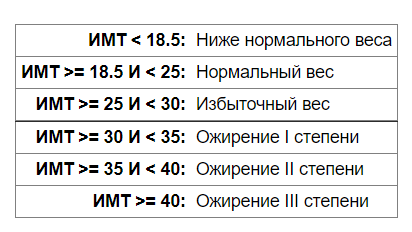

In [31]:
df_X = df_X[(df_X['bmi'] < max_outliers) | (df_X['bmi'] > min_outliers)]

#### 4.2 Сглаживание зашумленных признаков - биннинг 

Это техника обработки данных, при которой исходный набор данных делится на некоторое количество интервалов, общее значение которых затем представляет все значения интвервала, что позволяет уменьшить влияние отдельных наблюдений. Иными словами мы переводим непрерывную величину в дискретную.

$'bmi'$

bins_bmi:
* 'deficit': bmi < 18.5   
* 'norma': bmi < 25   
* 'excess': bmi < 30    
* 'obesity_1': bmi < 35
* 'obesity_2': bmi < 40
* 'obesity_3': bmi >= 40

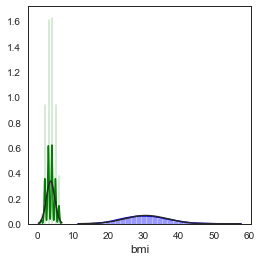

In [32]:
# bmi
sns.distplot(df_X['bmi'], fit=norm, kde=True, color='b')
df_X['bmi'] = df_X['bmi'].apply(lambda x: bins(x))      
sns.distplot(df_X['bmi'], fit=norm, kde=True, color='g')

$'age'$

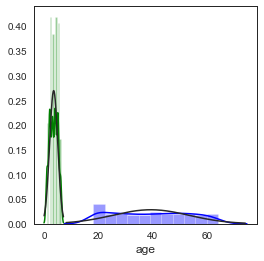

In [33]:
# age
sns.distplot(df_X['age'], fit=norm, kde=True, color='b')
df_X['age'] = np.floor_divide(np.asarray(df['age']), 10)
sns.distplot(df_X['age'], fit=norm, kde=True, color='g')

#### 4.3 Приближение распределения признака к нормальному

###### 4.3.1 Логарифмирование

Приблизим распределение признака 'bmi' к нормальному 

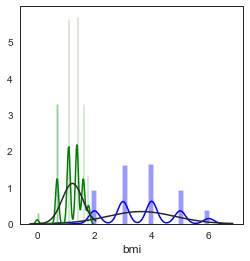

In [34]:
sns.distplot(df_X['bmi'], fit=norm, kde=True, color='b')
df_X['bmi'] = np.log(df_X['bmi'] + 0.0001).to_numpy() 
sns.distplot(df_X['bmi'], fit=norm, kde=True, color='g')

###### 4.3.2 Преобразование Бокса-Кокса, преобразование Йео-Джонсона

Приблизим распределение признака 'age' к нормальному 

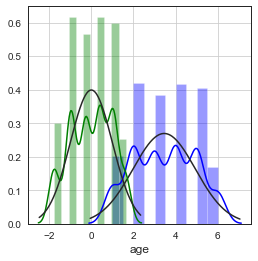

In [35]:
sns.distplot(df_X['age'], fit=norm, kde=True, color='b')
df_X['age'] = PowerTransformer(method='box-cox', standardize=True).fit_transform(df_X[['age']])
sns.distplot(df_X['age'], fit=norm, kde=True, color='g')
plt.grid()

#### 4.4 Добавление новых признаков (Feature Engineering)

###### 4.4.1 Бинаризация

Выбираем порог, значениям ниже которого присваивается одно значение, а выше - другое

In [36]:
df_X['children_bi'] =  [ 1 if x>2 else 0 for x in df_X.children] 

###### 4.4.2 PolynomialFeatures

In [37]:
PF = PolynomialFeatures(degree=3, include_bias=False)
col_PF = pd.DataFrame(PF.fit_transform(df_X[['age', 'bmi', 'children', 'children_bi']]), 
                      columns = PF.get_feature_names(['age', 'bmi', 'children', 'children_bi']))
                                            
# Удалим столбцы, повторяющиеся с df_X 
col_PF = col_PF.iloc[:, 4:]
col_PF

,age^2,age bmi,age children,age children_bi,bmi^2,bmi children,bmi children_bi,children^2,children children_bi,children_bi^2,...,bmi^3,bmi^2 children,bmi^2 children_bi,bmi children^2,bmi children children_bi,bmi children_bi^2,children^3,children^2 children_bi,children children_bi^2,children_bi^3
0,3.104933,-1.935904,-0.000000,-0.000000,1.207022,0.000000,0.000000,0.0,0.0,0.0,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,3.104933,-2.442809,-1.762082,-0.000000,1.921881,1.386319,0.000000,1.0,0.0,0.0,...,2.664341,1.921881,0.000000,1.386319,0.000000,0.000000,1.0,0.0,0.0,0.0
2,0.937584,-1.342358,-2.904868,-0.968289,1.921881,4.158958,1.386319,9.0,3.0,1.0,...,2.664341,5.765644,1.921881,12.476874,4.158958,1.386319,27.0,9.0,3.0,1.0
3,0.066596,-0.178888,-0.000000,-0.000000,0.480522,0.000000,0.000000,0.0,0.0,0.0,...,0.333097,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.066596,-0.283520,-0.000000,-0.000000,1.207022,0.000000,0.000000,0.0,0.0,0.0,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,1.059380,1.426886,3.087785,1.029262,1.921881,4.158958,1.386319,9.0,3.0,1.0,...,2.664341,5.765644,1.921881,12.476874,4.158958,1.386319,27.0,9.0,3.0,1.0
1333,3.104933,-2.442809,-0.000000,-0.000000,1.921881,0.000000,0.000000,0.0,0.0,0.0,...,2.664341,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1334,3.104933,-2.835997,-0.000000,-0.000000,2.590355,0.000000,0.000000,0.0,0.0,0.0,...,4.169067,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1335,0.937584,-1.063807,-0.000000,-0.000000,1.207022,0.000000,0.000000,0.0,0.0,0.0,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [38]:
df_X = pd.concat([df_X, col_PF], axis=1)
df = pd.concat([df_X, df_y], axis=1)
df_X

,age,sex,bmi,children,smoker,region,children_bi,age^2,age bmi,age children,...,bmi^3,bmi^2 children,bmi^2 children_bi,bmi children^2,bmi children children_bi,bmi children_bi^2,children^3,children^2 children_bi,children children_bi^2,children_bi^3
0,-1.762082,female,1.098646,0,yes,southwest,0,3.104933,-1.935904,-0.000000,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,-1.762082,male,1.386319,1,no,southeast,0,3.104933,-2.442809,-1.762082,...,2.664341,1.921881,0.000000,1.386319,0.000000,0.000000,1.0,0.0,0.0,0.0
2,-0.968289,male,1.386319,3,no,southeast,1,0.937584,-1.342358,-2.904868,...,2.664341,5.765644,1.921881,12.476874,4.158958,1.386319,27.0,9.0,3.0,1.0
3,-0.258063,male,0.693197,0,no,northwest,0,0.066596,-0.178888,-0.000000,...,0.333097,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,-0.258063,male,1.098646,0,no,northwest,0,0.066596,-0.283520,-0.000000,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,1.029262,male,1.386319,3,no,northwest,1,1.059380,1.426886,3.087785,...,2.664341,5.765644,1.921881,12.476874,4.158958,1.386319,27.0,9.0,3.0,1.0
1333,-1.762082,female,1.386319,0,no,northeast,0,3.104933,-2.442809,-0.000000,...,2.664341,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1334,-1.762082,female,1.609458,0,no,southeast,0,3.104933,-2.835997,-0.000000,...,4.169067,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1335,-0.968289,female,1.098646,0,no,southwest,0,0.937584,-1.063807,-0.000000,...,1.326090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


#### 4.5 Преобразование категориальных переменных в числовые и стандартизация данных

In [39]:
# находим категориальные признаки 
categor = df_X.select_dtypes(include=np.object).columns.tolist()
len(categor)

3

In [40]:
# посмотрим на количество категорий (значений) в категориальных признаках
for i in categor:
    print(f'{i}: {df[i].nunique()}')

sex: 2
smoker: 2
region: 4


Все категориальные данные содержат не большое количество уникальных значений (категорий).
Кодировщик OneHotEncoder создает функцию, которая сохраняется и затем может применяться к новым наборам данных, которые используют те же категориальные переменные, с согласованными результатами.

In [41]:
# числовые признаки 
numeric = df_X.select_dtypes(include=np.number).columns.tolist()
numeric

['age',
 'bmi',
 'children',
 'children_bi',
 'age^2',
 'age bmi',
 'age children',
 'age children_bi',
 'bmi^2',
 'bmi children',
 'bmi children_bi',
 'children^2',
 'children children_bi',
 'children_bi^2',
 'age^3',
 'age^2 bmi',
 'age^2 children',
 'age^2 children_bi',
 'age bmi^2',
 'age bmi children',
 'age bmi children_bi',
 'age children^2',
 'age children children_bi',
 'age children_bi^2',
 'bmi^3',
 'bmi^2 children',
 'bmi^2 children_bi',
 'bmi children^2',
 'bmi children children_bi',
 'bmi children_bi^2',
 'children^3',
 'children^2 children_bi',
 'children children_bi^2',
 'children_bi^3']

In [42]:
preprocessor = ColumnTransformer(
    [
        ("numerical", StandardScaler(), numeric),
        ("categorical", OneHotEncoder(handle_unknown="ignore", drop='if_binary', sparse=False), categor),
    ],
    verbose_feature_names_out=False,
).fit(df)

preprocessor.get_feature_names_out()

array(['age', 'bmi', 'children', 'children_bi', 'age^2', 'age bmi',
       'age children', 'age children_bi', 'bmi^2', 'bmi children',
       'bmi children_bi', 'children^2', 'children children_bi',
       'children_bi^2', 'age^3', 'age^2 bmi', 'age^2 children',
       'age^2 children_bi', 'age bmi^2', 'age bmi children',
       'age bmi children_bi', 'age children^2',
       'age children children_bi', 'age children_bi^2', 'bmi^3',
       'bmi^2 children', 'bmi^2 children_bi', 'bmi children^2',
       'bmi children children_bi', 'bmi children_bi^2', 'children^3',
       'children^2 children_bi', 'children children_bi^2',
       'children_bi^3', 'sex_male', 'smoker_yes', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype=object)

In [43]:
df = pd.concat([df_X, df_y], axis=1)
df_X = pd.DataFrame(preprocessor.fit_transform(df_X), columns = preprocessor.get_feature_names_out())
df_X

,age,bmi,children,children_bi,age^2,age bmi,age children,age children_bi,bmi^2,bmi children,...,children^3,children^2 children_bi,children children_bi^2,children_bi^3,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.762082,-0.368686,-0.909234,-0.419406,2.105104,-1.534883,-0.053341,-0.059591,-0.536888,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.762082,0.432449,-0.079442,-0.419406,2.105104,-1.927958,-1.368958,-0.059591,0.340641,0.024778,...,-0.373486,-0.379923,-0.410828,-0.419406,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.968289,0.432449,1.580143,2.384324,-0.062421,-1.074623,-2.222193,-3.066762,0.340641,1.778828,...,1.069725,1.640234,2.082107,2.384324,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.258063,-1.497808,-0.909234,-0.419406,-0.933479,-0.172419,-0.053341,-0.059591,-1.428706,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.258063,-0.368686,-0.909234,-0.419406,-0.933479,-0.253555,-0.053341,-0.059591,-0.536888,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,1.029262,0.432449,1.580143,2.384324,0.059385,1.072765,2.252082,3.136939,0.340641,1.778828,...,1.069725,1.640234,2.082107,2.384324,1.0,0.0,0.0,1.0,0.0,0.0
1333,-1.762082,0.432449,-0.909234,-0.419406,2.105104,-1.927958,-0.053341,-0.059591,0.340641,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,0.0,0.0,1.0,0.0,0.0,0.0
1334,-1.762082,1.053862,-0.909234,-0.419406,2.105104,-2.232853,-0.053341,-0.059591,1.161229,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,0.0,0.0,0.0,0.0,1.0,0.0
1335,-0.968289,-0.368686,-0.909234,-0.419406,-0.062421,-0.858622,-0.053341,-0.059591,-0.536888,-0.852247,...,-0.428994,-0.379923,-0.410828,-0.419406,0.0,0.0,0.0,0.0,0.0,1.0


### 5 Моделирование

#### 5.1 X, y

In [44]:
X = df_X
y = df_y

#### 5.2 Train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

#### 5.3 Модели

###### 5.3.1 Одиночные модели

In [47]:
estimators = [GradientBoostingRegressor(), AdaBoostRegressor(), LGBMRegressor(), HistGradientBoostingRegressor(), 
              RandomForestRegressor(), Ridge(), Lasso(), ElasticNet()] 

###### Hyperopt: оптимизация гиперпараметров

In [48]:
# Пространство поиска для hyperopt

search_spaces = {
    
    'GradientBoostingRegressor()':
    {'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
     'alpha': hp.quniform('alpha', 0.1, 0.9, 0.1),
     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
     'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
     'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
     'min_samples_split': scope.int(hp.quniform('min_samples_split', 1, 10, 1)),
     'subsample': hp.quniform('subsample', 0.3, 1., 0.1),
     'random_state': 42}, 
    
    'AdaBoostRegressor()':
    {'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
     'loss': hp.choice('loss', ['linear', 'square', 'exponential']),
     'random_state': 42},   
    
    'LGBMRegressor()':
    {'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
     'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)), 
     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)), 
     'subsample': hp.quniform('subsample', 0.3, 1, 0.1),
     'reg_alpha': hp.quniform('reg_alpha', 0, 1, 0.1),
     'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1)),
     'random_state': 42,                  
     'n_jobs': -1},
    
    'HistGradientBoostingRegressor()':
    {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)), 
     'max_iter': scope.int(hp.quniform('max_iter', 80, 120, 1)), 
     'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 1, 100, 5)), 
     'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 5)),  
     'min_samples_leaf':  scope.int(hp.quniform('min_samples_leaf', 5, 30, 5)), 
     'l2_regularization': hp.quniform('l2_regularization', 0., 1., 0.01), 
     'random_state': 42},
    
    'RandomForestRegressor()':
    {'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
     'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
     'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
     'min_samples_split': scope.int(hp.quniform('min_samples_split', 1, 15, 1)),
     'random_state': 42,
     'n_jobs': -1},
    
    'Ridge()':
    {'alpha': hp.loguniform('alpha', np.log(0.01), np.log(10)),
     'random_state': 42},
    
    'Lasso()':
    {'alpha': hp.loguniform('alpha', np.log(0.01), np.log(10)),
     'random_state': 42},
    
    'ElasticNet()':
    {'alpha': hp.loguniform('alpha', np.log(0.01), np.log(10)),
     'l1_ratio': hp.loguniform('l1_ratio', np.log(0.0001), np.log(1)),
     'random_state': 42}
}

In [49]:
for estimator in estimators:
    p = Class_hyperopt()
    print(estimator)
    p.objective(search_spaces[str(estimator)], estimator, X_train, y_train)
    print(p.for_hyperopt())
    print('___')

GradientBoostingRegressor()
  7%|███                                          | 68/1000 [00:43<10:01,  1.55trial/s, best loss: -0.8439570486824088]
{'alpha': 0.30000000000000004, 'learning_rate': 0.01390033009725997, 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 210, 'random_state': 42, 'subsample': 0.4}
___
AdaBoostRegressor()
  5%|██▍                                           | 52/1000 [01:36<29:25,  1.86s/trial, best loss: -0.832047214562279]
{'learning_rate': 0.01622362823819767, 'loss': 'exponential', 'n_estimators': 190, 'random_state': 42}
___
LGBMRegressor()
  3%|█▍                                           | 33/1000 [00:13<06:32,  2.46trial/s, best loss: -0.8420617949285576]
{'learning_rate': 0.03426399573932958, 'max_depth': 3, 'n_estimators': 390, 'n_jobs': -1, 'random_state': 42, 'reg_alpha': 0.2, 'reg_lambda': 0.9429639657684361, 'subsample': 0.6000000000000001}
___
HistGradientBoostingRegressor()
  2%|▉                                     

###### Установим модели с полученными гиперпараметрами, оставив лучшие

In [50]:
del estimators [5:]
estimators

[GradientBoostingRegressor(alpha=0.30000000000000004,
                           learning_rate=0.01390033009725997, min_samples_leaf=8,
                           min_samples_split=3, n_estimators=210,
                           random_state=42, subsample=0.4),
 AdaBoostRegressor(learning_rate=0.01622362823819767, loss='exponential',
                   n_estimators=190, random_state=42),
 LGBMRegressor(learning_rate=0.03426399573932958, max_depth=3, n_estimators=390,
               random_state=42, reg_alpha=0.2, reg_lambda=0.9429639657684361,
               subsample=0.6000000000000001),
 HistGradientBoostingRegressor(l2_regularization=0.41000000000000003,
                               learning_rate=0.040620979213929535, max_depth=35,
                               max_iter=106, max_leaf_nodes=40,
                               min_samples_leaf=10, random_state=42),
 RandomForestRegressor(max_depth=12, min_samples_leaf=3, min_samples_split=11,
                       n_estimators=60, 

In [51]:
estimators_chek_1 = estimators.copy()
estimators_chek_2 = []

for i in estimators:
    string = str(i)
    substring = 'LGBMR'
        
    if substring in string: 
        estimators_chek_1.pop(estimators_chek_1.index(i))
        estimators_chek_2.append(i)
    else:
        continue

print(estimators_chek_1)
print('____')
print(estimators_chek_2)

[GradientBoostingRegressor(alpha=0.30000000000000004,
                          learning_rate=0.01390033009725997, min_samples_leaf=8,
                          min_samples_split=3, n_estimators=210,
                          random_state=42, subsample=0.4), AdaBoostRegressor(learning_rate=0.01622362823819767, loss='exponential',
                  n_estimators=190, random_state=42), HistGradientBoostingRegressor(l2_regularization=0.41000000000000003,
                              learning_rate=0.040620979213929535, max_depth=35,
                              max_iter=106, max_leaf_nodes=40,
                              min_samples_leaf=10, random_state=42), RandomForestRegressor(max_depth=12, min_samples_leaf=3, min_samples_split=11,
                      n_estimators=60, n_jobs=-1, random_state=42)]
____
[LGBMRegressor(learning_rate=0.03426399573932958, max_depth=3, n_estimators=390,
              random_state=42, reg_alpha=0.2, reg_lambda=0.9429639657684361,
              subsample=

GradientBoostingRegressor(alpha=0.30000000000000004,
                          learning_rate=0.01390033009725997, min_samples_leaf=8,
                          min_samples_split=3, n_estimators=210,
                          random_state=42, subsample=0.4)
r2 = 0.8785762119511585
mape = 0.38968237426852337
RMSE = 4582.0699137586
cross_val_score = 0.8481232012271762


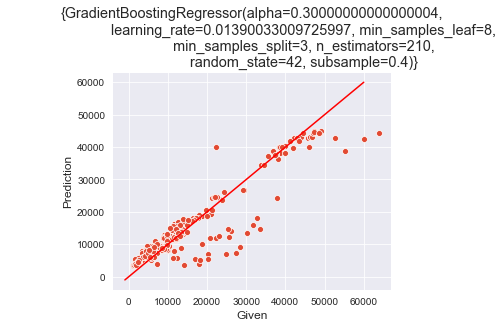

AdaBoostRegressor(learning_rate=0.01622362823819767, loss='exponential',
                  n_estimators=190, random_state=42)
r2 = 0.8559919601567543
mape = 0.6068651466675001
RMSE = 4990.030409528078
cross_val_score = 0.8334146498137949


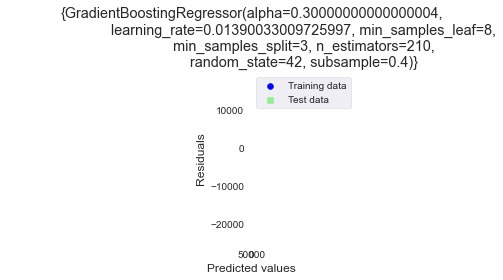

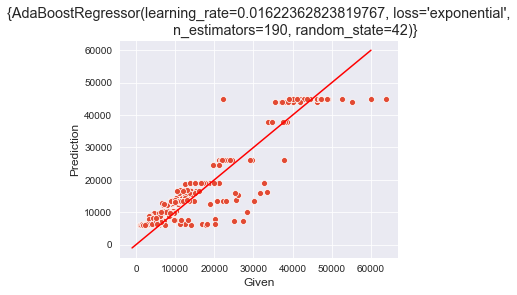

HistGradientBoostingRegressor(l2_regularization=0.41000000000000003,
                              learning_rate=0.040620979213929535, max_depth=35,
                              max_iter=106, max_leaf_nodes=40,
                              min_samples_leaf=10, random_state=42)
r2 = 0.8770575781178754
mape = 0.31665714602735767
RMSE = 4610.634597245571
cross_val_score = 0.845955083785128


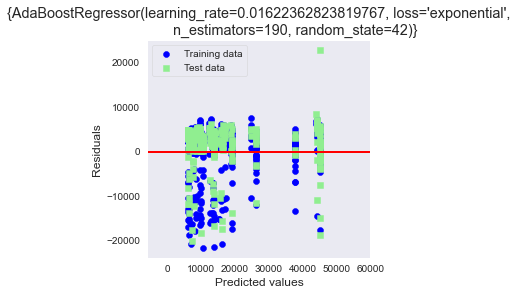

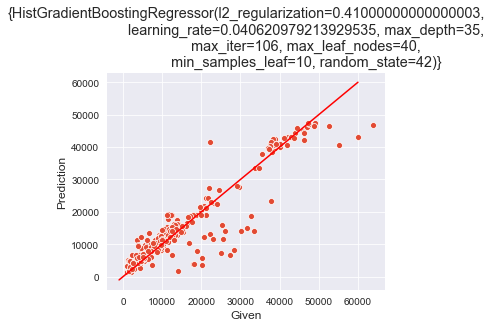

RandomForestRegressor(max_depth=12, min_samples_leaf=3, min_samples_split=11,
                      n_estimators=60, n_jobs=-1, random_state=42)
r2 = 0.8805455689662118
mape = 0.30050374280653674
RMSE = 4544.760008842504
cross_val_score = 0.8472287356389616


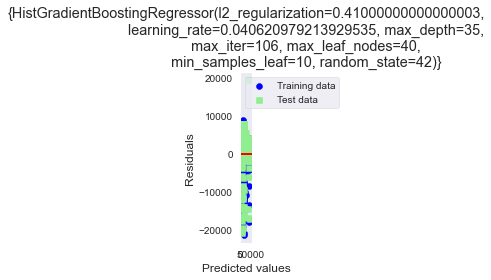

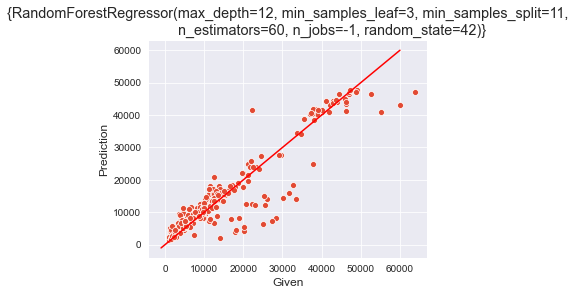

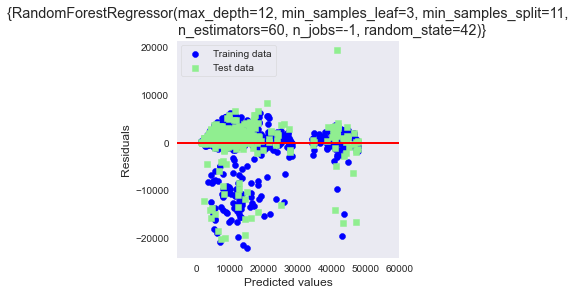

In [52]:
for estimator_chek in estimators_chek_1:
    r_1 = Class_score_1()
    print(r_1.get_model(estimator_chek, X_train, y_train, X_test, y_test))
    print(f'r2 = {r_1.r2()}')
    print(f'mape = {r_1.MAPE()}')
    print(f'RMSE = {r_1.RMSE()}')
    print(f'cross_val_score = {r_1.cross_val()}')
    r_1.plot()
    r_1.leftovers()
    r_1.data(str(estimator_chek))

[1]	training's rmse: 11396.6	training's l2: 1.29883e+08	valid_1's rmse: 12787.6	valid_1's l2: 1.63522e+08
[2]	training's rmse: 11076.7	training's l2: 1.22693e+08	valid_1's rmse: 12417.1	valid_1's l2: 1.54185e+08
[3]	training's rmse: 10769.4	training's l2: 1.15981e+08	valid_1's rmse: 12060.8	valid_1's l2: 1.45462e+08
[4]	training's rmse: 10474.4	training's l2: 1.09713e+08	valid_1's rmse: 11718.4	valid_1's l2: 1.37321e+08
[5]	training's rmse: 10191.2	training's l2: 1.03861e+08	valid_1's rmse: 11389.3	valid_1's l2: 1.29716e+08
[6]	training's rmse: 9919.53	training's l2: 9.83971e+07	valid_1's rmse: 11072.6	valid_1's l2: 1.22602e+08
[7]	training's rmse: 9658.93	training's l2: 9.32949e+07	valid_1's rmse: 10775	valid_1's l2: 1.161e+08
[8]	training's rmse: 9409.04	training's l2: 8.85301e+07	valid_1's rmse: 10482.8	valid_1's l2: 1.09888e+08
[9]	training's rmse: 9169.5	training's l2: 8.40797e+07	valid_1's rmse: 10207.8	valid_1's l2: 1.04199e+08
[10]	training's rmse: 8939.99	training's l2: 7.9923

r2 = 0.8834736776801035
mape = 0.31959594907196853
RMSE = 4488.71304526858
cross_val_score = 0.8466946275762648


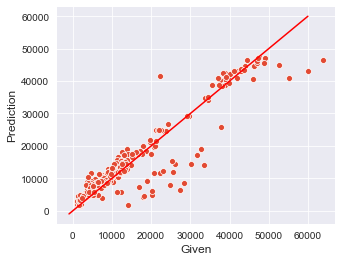

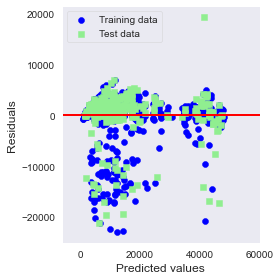

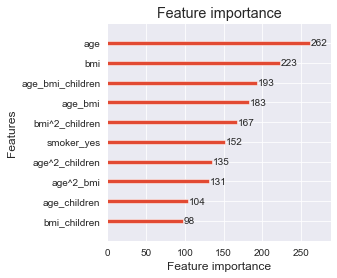

In [53]:
for estimator_chek in estimators_chek_2:
    r_2 = Class_score_2()
    r_2.get_model(estimator_chek, X_train, y_train, X_test, y_test)
    print(f'r2 = {r_2.r2()}')
    print(f'mape = {r_2.MAPE()}')
    print(f'RMSE = {r_2.RMSE()}')
    print(f'cross_val_score = {r_2.cross_val()}')
    r_2.plot()
    r_2.leftovers()
    r_2.plot_importance()
    r_2.data(estimator_chek)

###### 5.3.2 XGBRegressor

In [54]:
xgb_model = XGBRegressor()
xgb_name = 'XGBRegressor()'

In [55]:
def objective(xgb_params):
    global xgb_model
    
    xgb_model = XGBRegressor(
          n_estimator=xgb_params['n_estimator'],
          learning_rate=xgb_params['learning_rate'],
          gamma=xgb_params['gamma'],
          max_depth=int(xgb_params['max_depth']),
          min_child_weight=int(xgb_params['min_child_weight']),
          colsample_bytree=int(xgb_params['colsample_bytree']),
          reg_lambda=xgb_params['reg_lambda'],
          reg_alpha=xgb_params['reg_alpha'],
          booster = xgb_params['booster'],
          random_state = xgb_params['random_state'],
          n_jobs = xgb_params['n_jobs']
        
    )
    
    cv = KFold(n_splits=10)
    cross = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1).mean()
    return  {'loss': - cross, 'status': STATUS_OK}         

params={'n_estimator': scope.int(hp.quniform('n_estimator', 100, 500, 10)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
        'gamma': hp.loguniform('gamma', np.log(0.05), np.log(1)),
        'max_depth': scope.int(hp.quniform('max_depth', 3, 25, 1)),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 7, 1),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1.0, 0.1),
        'reg_lambda' : hp.loguniform('reg_lambda', np.log(0.01), np.log(1)),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.1),
        'booster':hp.choice('booster',['gbtree','dart','gblinear']),
        'random_state': 42,
        'n_jobs': -1
       }


trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate=np.random.RandomState(1),
                        show_progressbar=True,
                        early_stop_fn=no_progress_loss(20))

 66%|███████████████████████████████                | 66/100 [03:22<01:44,  3.07s/trial, best loss: -0.839156282907496]


In [56]:
xgb_model

XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1,
             enable_categorical=False, gamma=0.2137953308220289, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0858333530435855, max_delta_step=None, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimator=360, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0.30000000000000004, reg_lambda=0.01575792056411912,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

[18:21:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:16172.62695	validation_1-rmse:17563.94141
[1]	validation_0-rmse:14904.09863	validation_1-rmse:16178.02734
[2]	validation_0-rmse:13754.17285	validation_1-rmse:14902.42383
[3]	validation_0-rmse:12713.33008	validation_1-rmse:13765.00684
[4]	validation_0-rmse:11772.25391	validation_1-rmse:12718.31543
[5]	validation_0-rmse:10922.20996	validation_1-rmse:11788.10547
[6]	validation_0-rmse:10156.68848	validation_1-rmse:10949.26953
[7]	validation_0-rmse:9468.00684	validation_1-rmse:10192.57031
[8]	validation_0-rmse:8850.41894	validation_1-rmse:9500.49316
[9]	val

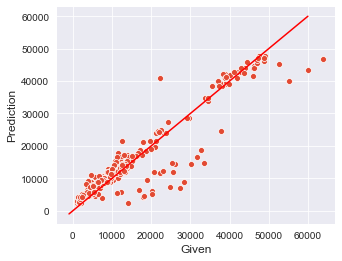

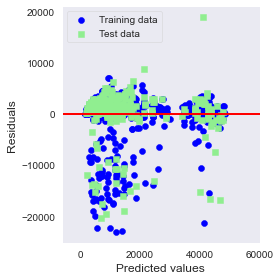

In [57]:
r_2.get_model(xgb_model, X_train, y_train, X_test, y_test)
print(f'r2 = {r_2.r2()}')
print(f'mape = {r_2.MAPE()}')
print(f'RMSE = {r_2.RMSE()}')
print(f'cross_val_score = {r_2.cross_val()}')
r_2.plot()
r_2.leftovers()
r_2.data(xgb_name)

###### 5.3.3 Стекинг  StackingRegressor

Многоуровневая регрессия.  
Индивидуальные регрессионные модели обучаются на основе полного набора обучающих данных;  
затем устанавливается мета-регрессор на основе выходных данных этих отдельных регрессионных моделей.  

In [58]:
mod_st = StackingRegressor(
    [
        ('gbr', estimators_chek_1[0]),
        ('hgb', estimators_chek_1[2]),
        ('rf', estimators_chek_1[3]),
        ('xgb', xgb_model)
    ],
LinearRegression())

In [59]:
mod_st_name = 'StackingRegressor()'

[18:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This c

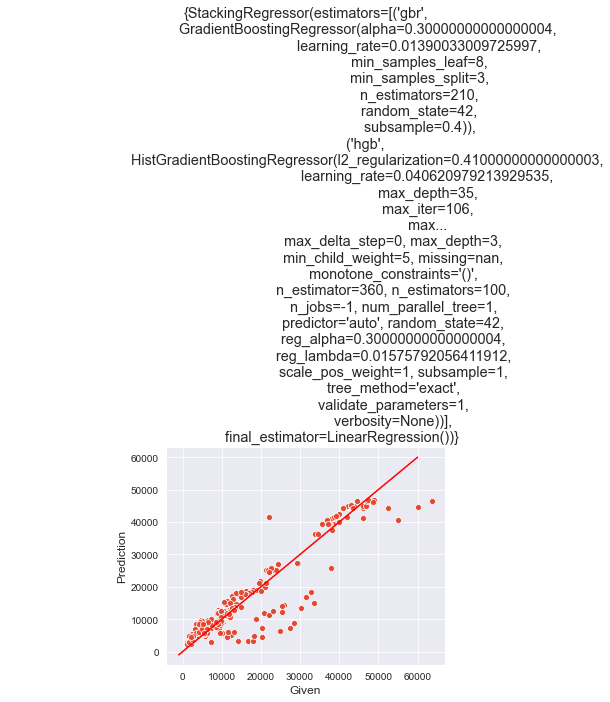

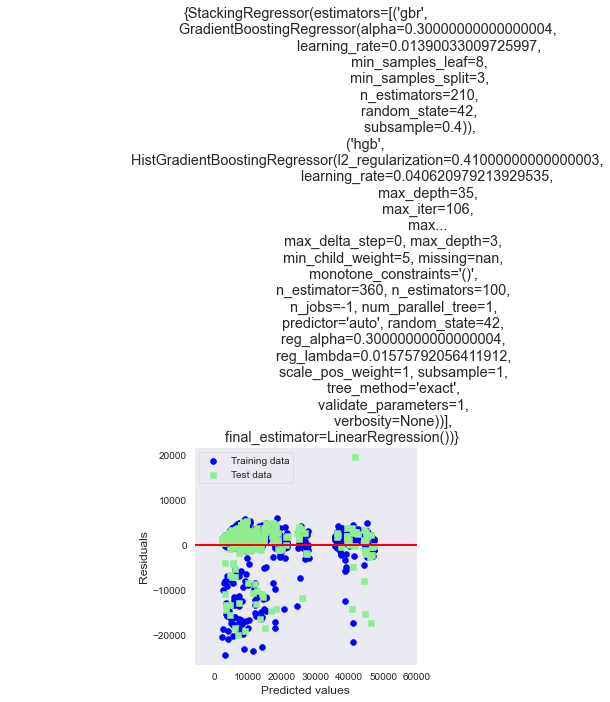

In [60]:
r_1.get_model(mod_st, X_train, y_train, X_test, y_test)
print(f'r2 = {r_1.r2()}')
print(f'mape = {r_1.MAPE()}')
print(f'RMSE = {r_1.RMSE()}')
print(f'cross_val_score = {r_1.cross_val()}')
r_1.plot()
r_1.leftovers()
r_2.data(mod_st_name)

### 6. Выбор итоговой модели. Сохранение

In [61]:
sort = scorr_dataset.sort_values(by='cross_val_score', ascending=False, ignore_index=True)
sort

,model,name,r2,cross_val_score
0,([DecisionTreeRegressor(criterion='friedman_ms...,GradientBoostingRegressor(alpha=0.300000000000...,0.878576,0.848123
1,"(DecisionTreeRegressor(max_depth=12, max_featu...","RandomForestRegressor(max_depth=12, min_sample...",0.880546,0.847229
2,LGBMRegressor(learning_rate=0.0342639957393295...,LGBMRegressor(learning_rate=0.0342639957393295...,0.883474,0.846695
3,"XGBRegressor(base_score=0.5, booster='gbtree',...",XGBRegressor(),0.884316,0.846316
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",StackingRegressor(),0.884316,0.846316
5,HistGradientBoostingRegressor(l2_regularizatio...,HistGradientBoostingRegressor(l2_regularizatio...,0.877058,0.845955
6,"(DecisionTreeRegressor(max_depth=3, random_sta...",AdaBoostRegressor(learning_rate=0.016223628238...,0.855992,0.833415


Выберем в качестве итоговой модели GradientBoostingRegressor()

In [62]:
# Итоговая модель
my_model = sort['name'][0]
print(f'Выберем в качестве итоговой модели - {my_model}')

Выберем в качестве итоговой модели - GradientBoostingRegressor(alpha=0.30000000000000004,
                          learning_rate=0.01390033009725997, min_samples_leaf=8,
                          min_samples_split=3, n_estimators=210,
                          random_state=42, subsample=0.4)


In [63]:
# Предсказание модели
predicts[my_model]

array([ 8124.06290758,  9327.93889022, 16281.16716394, 38125.45986222,
        6811.54999553,  9970.70908928, 38037.68823323,  5505.31215486,
       10430.7810401 ,  9278.54834051, 13478.13819239, 26076.9817966 ,
       37873.47510418, 13311.71195609,  7102.55680307,  9424.48845273,
        4897.28764537, 39894.56339314,  7175.70065207,  5095.92150906,
        4363.27948697, 19558.29203978, 11033.84031385, 19345.81219311,
       38927.12773684,  7297.00112409, 43074.25831971, 42815.21787215,
        9389.56567421, 11553.14360892,  6002.56759124, 12752.85478382,
        4012.26383594, 11736.95337655, 44334.08426477, 12230.03831682,
        9060.40610058,  7495.589384  , 24162.56525948,  9064.43810639,
        4320.32857399, 20667.8569194 , 42735.30632864, 12234.90887355,
        8975.30336551,  4483.52208495,  3882.35283147,  9021.19093829,
        5187.75378704,  7064.9112561 ,  6991.41555474,  5198.4613064 ,
       24637.06574426,  4237.95162298,  9853.86663813,  9491.49526037,
      

In [64]:
# Сохранение итоговой модели
joblib.dump(my_model, 'my_model.joblib')

# Загрузка модели
loaded_my_model = joblib.load('my_model.joblib')

### 7. Литература

КУРСОВАЯ РАБОТА СТУДЕНТА 317 ГРУППЫ
«Методы восстановления пропусков в данных»
http://www.machinelearning.ru/wiki/images/9/90/Kayumov_course_work_imputer_methods.pdf
    

Блог об аналитике, визуализации данных, data science и BI  
https://leftjoin.ru/all/outliers-detection-in-python/  
    

5 способов обнаружить выбросы / аномалии, которые должен знать каждый специалист по данным (код Python)  
https://www.machinelearningmastery.ru/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623/  

Работа с признаками как часть машинного обучения  
https://nagornyy.me/it/rabota-s-priznakami-kak-chast-mashinnogo-obucheniia/  

Индекс массы тела Википедия  
https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BC%D0%B0%D1%81%D1%81%D1%8B_%D1%82%D0%B5%D0%BB%D0%B0  

Python - метод seaborn.lmplot ()  
https://www.geeksforgeeks.org/python-seaborn-lmplot-method/  

Линейная регрессия с использованием нейронных сетей (PyTorch)  
https://www.reneshbedre.com/blog/pytorch-regression.html  

Быстрый старт  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html  